# TO·Pi·cks:

## Forecast Consumer-Interest in Topics

__Author: Tarun Gupta  
  Company: Insight Data Science  
  Location: Toronto, ON__   
  Date: Januray 2019  
  Github: https://github.com/tguptaMT/TOPicks  
  __About:__ Powered by NLP and machine-learning based time-series forecasting, TO·Pi·cks is a consumer-engagement and popularity forecasting tool. See ReadMe file for more details. 
  
  _This is the __fourth and the last__ notebook in a series of Jupyter notebooks associated with TOPicks. There are additional .py modules required for web deployment._

### Step4: User-IO:

- __Load:__
    - Models:
        - load trained word2vec model for finding synonyms to user-typed keyword.
        - load trained NMF model to match user input to topics.
    - Data:
        - load predictions made by time-series forecasting model
- __ Input:__
    - Ask the user to input 3 potential topics of interest.
    - OR Choose from 3 different drop-down menus.
- __Process:__
    - Find related topics by w2v.
    - Match user-input to topic cluster
    - repeat for all inputs
- __Output:__
    - Display comparative weekly predictions for all inputs over the next 2 months.

In [4]:
import gensim
import random
from gensim.models import Word2Vec
from joblib import load
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for Plotly Offline:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

#### Define Functions

In [318]:
def user2topic(uinput):
    """
    uInput: User Input -  string; ngram=(1, 2)' 
    Function: 
        - transform user input with trained NMF model to match against the topic.
        - If topic not found in first pass in case the model has never seen the user input before,
          find synonyms with the trained word2vec model and then pass the synonyms through NMF.
    Output: Matched topic number. Default: 0 (That is, misc. category)
    """
    try:
        user_nmf = nmf.transform(vectorizer.transform([uinput]))[0]
        matched_topic = user_nmf.argmax()
        if matched_topic == 0: # try synonyms to user-input from word2vec 
            user2similar = w2v.wv.most_similar(positive=uinput,topn=10)
            related_topics = [x for x in list(sum(user2similar, ())) if str(x).isalpha()]
            user_nmf = nmf.transform(vectorizer.transform([" ".join(related_topics)]))[0]
            matched_topic = user_nmf.argmax()
        return matched_topic
    except KeyError:
        return 0

### Load Data and Models:

In [104]:
try:  
    ############## load previously trained models ##############
    # word2vec model for synonyms:
    w2v = Word2Vec.load("TOPicks/model/word2vec/w2v_bigram.model")
    # NMF topic models for matching user input to topics:
    nmf = load('TOPicks/model/nmf/latest_nmf_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib') 
    vectorizer = load('TOPicks/model/nmf/latest_tfidf_tfidf_ntop-200_nftr_50000_ngrams_(1, 3)_.joblib')

    # import data containing topic assignments from Step2:
    tp_name = 'TOPicks/data/parquet_data/step2_NMF_topics=200_assigned.parquet'
    pilot = pd.read_parquet(tp_name, engine='pyarrow')
    all_topics_fname = 'TOPicks/data/json_data/all_topics_nmf_ntop-200_nftr_50000_ngrams_(1, 3).json'
    with open(all_topics_fname, 'r') as fp:
        all_topics = json.load(fp)

    # File with time-series analytics for that topic:
    ts_name = 'TOPicks/data/ts_predictions/all_preds_ts_gb_hptuning=False_nmf_ntopics=198.parquet'
    predictions = pd.read_parquet(ts_name, engine='pyarrow')
except:
    print("One of the required models / data files not found.")
    

### User Input:

When a new headline or a topic is entered by the user, feed it through pretrained word2vec to find similar embeddings (Top10 similar words). Then use those to create a sentence / document of highly related words to feed into tfidf-nmf pipeline for matching user-input to the list of predicted topics within our corpus. This process will increase mapping specificity.

Some Topic Suggestions to get you started:
 Law, Tax, climate change, Ebola, guns, Russia, Mexico, Phone..

62 Iphone Apple
90 Modi India
45 Gun Control


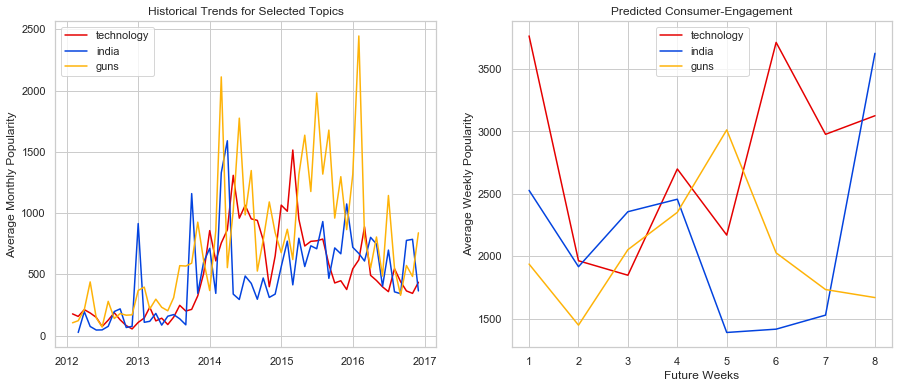

In [319]:
#######################################################################
# HAVE A USER ENTER 3 CANDIDATE TOPICS OF INTEREST. 
## QUERY AGAINST INTERNAL TOPICS:
#######################################################################
print("Some Topic Suggestions to get you started:\n Law, Tax, climate change, Ebola, guns, Russia, Mexico, Phone..\n")
user_inputs, all_related_topics = [], []
for i in range(3):
    user_inputs.append(input("Enter topic # {} of interest: ".format(str(i+1))).lower())

all_matched_topics=[]
for uinput in user_inputs:
    try:
        matched_topic = user2topic(uinput)
        if matched_topic == 0:
            matched_topic = user2topic(uinput[:-1]) # try removing the last char ('s)
            if matched_topic == 0:
                matched_topic = user2topic(uinput[:-2]) # try removing the last 2 chars ('es)
                
        # sanity check for debugging:
        print(matched_topic, all_topics[str(matched_topic)])
        
    except KeyError:
        user2similar = ''
        pass
    
    all_matched_topics.append(matched_topic)

#######################################################################
# EXTRACT TOPIC DATA FOR FORECASTING
#######################################################################

utopics = {}
for topic in all_matched_topics:
    utopics[topic] = pilot[pilot['predicted_topic'] == topic].set_index('date')\
                                                        ['likes_count'].resample('M').median()
        

#######################################################################
# PLOT HISTORICAL AND PREDICTIVE ANALYTICS FOR TOPIC POPULARITY
#######################################################################
sns.set(style="whitegrid")
colors = ["red", "blue", "amber"]
sns.set_palette(sns.xkcd_palette(colors))

fig1, ax = plt.subplots(figsize=(15,6))
ax=plt.subplot(121)
try:
    for key, v in utopics.items():
        label_ = [each[0] for each in zip(user_inputs, all_matched_topics) if key in each][0]
        ax.plot(v, label=label_)
    ax.set_title("Historical Trends for Selected Topics")
    ax.set_ylabel("Average Monthly Popularity")
    plt.legend()

    ax=plt.subplot(122)
    for key in utopics.keys():
        v = predictions[predictions['predicted_topic']==key][-8:].reset_index()\
            ['preds_likes_gb']
        label_ = [each[0] for each in zip(user_inputs, all_matched_topics) if key in each][0]
        ax.plot(v, label=label_)
    ax.set_title("Predicted Consumer-Engagement")
    ax.set_xlabel("Future Weeks")
    ax.set_ylabel("Average Weekly Popularity")
    ax.set_xticklabels(list(range(0,9)))
    plt.legend()
    plt.show()
except IndexError:
    pass


### Plot Interactive graph in in Plotly

In [311]:
allts = []
for key, ts in utopics.items():
    label = [each[0] for each in zip(user_inputs, all_matched_topics) if key in each][0]
    x = ts.index
    y = ts.values
    allts.append(go.Scatter(
        x=x, y=y, name=label))
# Layout goes separately
layout = go.Layout(
    title='Comparative Historical Trends',
    xaxis=dict(
        title='Time',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    
    yaxis=dict(
        title='Median Weekly Popularity',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=allts, layout=layout)
iplot(fig)
    

'file:///Users/tg/Google Drive/Academic/Python/Projects/Insight_2019_Toronto/temp-plot.html'